In [1]:
from random import sample

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import DataStructs
from sklearn.metrics import roc_auc_score

import torch
from torch.nn import ReLU
from torch.nn import Dropout
from torch.nn import Linear
from torch.nn import Sequential
from torch.optim import Adam
from torch.nn import CrossEntropyLoss

In [2]:
def fp_from_smi(smi, nbits=2048):
    mol = Chem.MolFromSmiles(smi)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 3, nBits=nbits)

    fingerprint = np.zeros((0, ), dtype=np.uint8)
    DataStructs.ConvertToNumpyArray(fp, fingerprint)
    return fingerprint

Our target metric is ROC-AUC, so balancing the training set to have a 50-50 ratio is a good idea.

In [3]:
def sample_batch_backprop_net(pos_X, neg_X, pos_y, neg_y, batch_size):
    n_half = batch_size // 2
    pos_sample_idx = sample(range(len(pos_X)), n_half)
    neg_sample_idx = sample(range(len(neg_X)), n_half)
    
    X_out = np.append(pos_X[pos_sample_idx], neg_X[neg_sample_idx],axis=0)
    y_out = np.append(pos_y[pos_sample_idx], neg_y[neg_sample_idx],axis=0)
    return X_out, y_out

def sample_batch_ff_net(pos_X, neg_X, batch_size):
    n_half = batch_size // 2
    pos_sample_idx = sample(range(len(pos_X)), n_half)
    neg_sample_idx = sample(range(len(neg_X)), n_half)
    
    return pos_X[pos_sample_idx], neg_X[neg_sample_idx]

In [4]:
class SimpleDenseNet(torch.nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims, dropout=0.0):
        super().__init__()
        
        hidden_dims = [input_dim] + hidden_dims + [output_dim]
        layers = []
        for (in_dim, out_dim) in zip(hidden_dims[:-1], hidden_dims[1:]):
            layers.append(Linear(in_dim, out_dim))
            layers.append(ReLU())
            if dropout > 0:
                layers.append(Dropout(p=dropout))
        if dropout > 0:
            self.mlp = Sequential(*layers[:-2])
        else:
            self.mlp = Sequential(*layers[:-1])
            
    def forward(self, x):
        return self.mlp(x)

The code below is adapted from the [pytorch_forward_forward](https://github.com/mohammadpz/pytorch_forward_forward) repo.

In [5]:
class ForwardForwardNet(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, dropout=0.0):
        super().__init__()
        
        hidden_dims = [input_dim] + hidden_dims
        self.layers = []
        for (in_dim, out_dim) in zip(hidden_dims[:-1], hidden_dims[1:]):
            self.layers += [Layer(in_dim, out_dim, dropout)]
        
    def predict(self, x):
        h = x
        goodness = []
        for layer in self.layers:
            h = layer(h)
            goodness += [h.pow(2).mean(1)]
        
        return sum(goodness)

    def ff_train(self, x_pos, x_neg):
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            h_pos, h_neg = layer.train(h_pos, h_neg)
            
        
class Layer(torch.nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0, threshold=2.0, opt_iters=10, lr=0.001):
        super().__init__()
        
        self.threshold = threshold
        self.opt_iters = opt_iters

        layers = []
        layers.append(Linear(in_dim, out_dim))
        layers.append(ReLU())
        if dropout > 0:
            layers.append(Dropout(p=dropout))
            
        if dropout > 0:
            self.mlp = Sequential(*layers[:-2])
        else:
            self.mlp = Sequential(*layers[:-1])
            
        self.optimizer = Adam(self.parameters(), lr=lr)
            
    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.mlp(x_direction)

    def train(self, x_pos, x_neg):
        for i in range(self.opt_iters):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([-g_pos + self.threshold, g_neg - self.threshold]))).mean()
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        return self.forward(x_pos).detach(), self.forward(x_neg).detach()

In [6]:
def eval_dense_model(model, X_test, y_test, batch_size):
    model.eval()
    out = model(torch.tensor(X_test).float())
    y_pred = (torch.max(out, 1)[1])
    y_pred = np.squeeze(np.asarray(y_pred.numpy()))
    return roc_auc_score(y_test, y_pred)

DRD2 sets are taken from the [REINVENT](https://github.com/MolecularAI/ReinventCommunity/tree/master/notebooks/data) repo. It's relatively easy to get a pretty good performance (ROC-AUC > 0.9), so it a good "toy" problem to test the Forward-Forward Algorithm.

In [7]:
train_file = './data/drd2.train.csv'
test_file = './data/drd2.test.csv'

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

train_df_pos = train_df[train_df['activity'] == 1]
train_df_neg = train_df[train_df['activity'] == 0]
train_X_arr_pos = np.array([fp_from_smi(smi) for smi in list(train_df_pos.canonical)])
train_y_arr_pos = np.array(list(train_df_pos.activity))
train_X_arr_neg = np.array([fp_from_smi(smi) for smi in list(train_df_neg.canonical)])
train_y_arr_neg = np.array(list(train_df_neg.activity))
tr_act = len(train_df_pos)
tr_inact = len(train_df_neg)
print(f'Total number of compounds in the TRAINING set: {len(train_df)}')
print(f'Number of active compounds (1): {tr_act}; number of inactive compounds (0): {tr_inact}\n')


test_X_arr = np.array([fp_from_smi(smi) for smi in list(test_df.canonical)])
test_y_arr = np.array(list(test_df.activity))
te_total = len(test_df)
te_act = sum(test_y_arr)
print(f'Total number of compounds in the TEST set: {te_total}')
print(f'Number of active compounds (1): {te_act}; number of inactive compounds (0): {te_total - te_act}\n')

Total number of compounds in the TRAINING set: 275768
Number of active compounds (1): 3448; number of inactive compounds (0): 272320

Total number of compounds in the TEST set: 68944
Number of active compounds (1): 863; number of inactive compounds (0): 68081



The DRD2 daset is an easy one, so we run a relatively small model -- just for 100 iterations. 

In [8]:
input_dim = 2048
num_iters = 100
batch_size = 128
lr = 0.001
dropout = 0.0
hidden_dims = [256, 128]

simple_net_performance = []
ff_net_performance = []

In [9]:
dense_model = SimpleDenseNet(input_dim=input_dim, output_dim=2,
                                      hidden_dims=hidden_dims, dropout=dropout)

optimizer = Adam(dense_model.parameters(), lr=lr)

loss_ce = CrossEntropyLoss()
for iter_ in range(num_iters):
    dense_model.train()
    optimizer.zero_grad()
    (X,y) = sample_batch_backprop_net(train_X_arr_pos, train_X_arr_neg, 
                                      train_y_arr_pos, train_y_arr_neg, batch_size=batch_size)
    
    
    X_tensor = torch.tensor(X).float()
    out = dense_model(X_tensor)
    loss = loss_ce(out.squeeze(), torch.tensor(y).type(torch.LongTensor))
    loss.backward()
    optimizer.step()
    
    roc_auc_val = eval_dense_model(dense_model, test_X_arr, test_y_arr, batch_size)
    simple_net_performance.append(roc_auc_val)
    if (iter_ + 1) % 5 == 0:
        print(f'Iter: {iter_+1}, Test ROC-AUC: {roc_auc_val}')

Iter: 5, Test ROC-AUC: 0.9313808139690737
Iter: 10, Test ROC-AUC: 0.9412301851674432
Iter: 15, Test ROC-AUC: 0.9489007819616682
Iter: 20, Test ROC-AUC: 0.9528845853866081
Iter: 25, Test ROC-AUC: 0.9571434173488016
Iter: 30, Test ROC-AUC: 0.9527997144291844
Iter: 35, Test ROC-AUC: 0.9349036182328175
Iter: 40, Test ROC-AUC: 0.9542783396023921
Iter: 45, Test ROC-AUC: 0.9597073406340341
Iter: 50, Test ROC-AUC: 0.9530249760598883
Iter: 55, Test ROC-AUC: 0.9652856679155425
Iter: 60, Test ROC-AUC: 0.9645088173972034
Iter: 65, Test ROC-AUC: 0.9587216103753992
Iter: 70, Test ROC-AUC: 0.9640436823405587
Iter: 75, Test ROC-AUC: 0.9640191988607123
Iter: 80, Test ROC-AUC: 0.9629975560942734
Iter: 85, Test ROC-AUC: 0.9630122444801666
Iter: 90, Test ROC-AUC: 0.9669340264935249
Iter: 95, Test ROC-AUC: 0.9686019752594138
Iter: 100, Test ROC-AUC: 0.9653215804233466


In [10]:
ff_model = ForwardForwardNet(input_dim=input_dim, hidden_dims=hidden_dims, dropout=dropout)

for iter_ in range(num_iters):
    ff_model.train()
    (X_pos, X_neg) = sample_batch_ff_net(train_X_arr_pos, train_X_arr_neg, batch_size=batch_size)
    
    
    X_pos = torch.tensor(X_pos).float()
    X_neg = torch.tensor(X_neg).float()
    
    ff_model.ff_train(X_pos, X_neg)
    
    y_pred = ff_model.predict(torch.tensor(test_X_arr).float())
    y_pred = y_pred.detach().numpy()
    roc_auc_val = roc_auc_score(test_y_arr, y_pred)
    ff_net_performance.append(roc_auc_val)
    if (iter_ + 1) % 5 == 0:
        print(f'Iter: {iter_+1}, Test ROC-AUC: {roc_auc_val}')

Iter: 5, Test ROC-AUC: 0.8790943556549766
Iter: 10, Test ROC-AUC: 0.8964738989339993
Iter: 15, Test ROC-AUC: 0.9347269831588889
Iter: 20, Test ROC-AUC: 0.9650256256167355
Iter: 25, Test ROC-AUC: 0.9753141591291391
Iter: 30, Test ROC-AUC: 0.9807545551484469
Iter: 35, Test ROC-AUC: 0.9834089405090246
Iter: 40, Test ROC-AUC: 0.9855801239281073
Iter: 45, Test ROC-AUC: 0.9866296797337872
Iter: 50, Test ROC-AUC: 0.9875544523399578
Iter: 55, Test ROC-AUC: 0.9881517147890585
Iter: 60, Test ROC-AUC: 0.9885923153054189
Iter: 65, Test ROC-AUC: 0.9889999988596502
Iter: 70, Test ROC-AUC: 0.9894348891170686
Iter: 75, Test ROC-AUC: 0.9898163701567196
Iter: 80, Test ROC-AUC: 0.9902520348307755
Iter: 85, Test ROC-AUC: 0.9903723587520645
Iter: 90, Test ROC-AUC: 0.9904696544159799
Iter: 95, Test ROC-AUC: 0.9906111769289608
Iter: 100, Test ROC-AUC: 0.9907552354436777


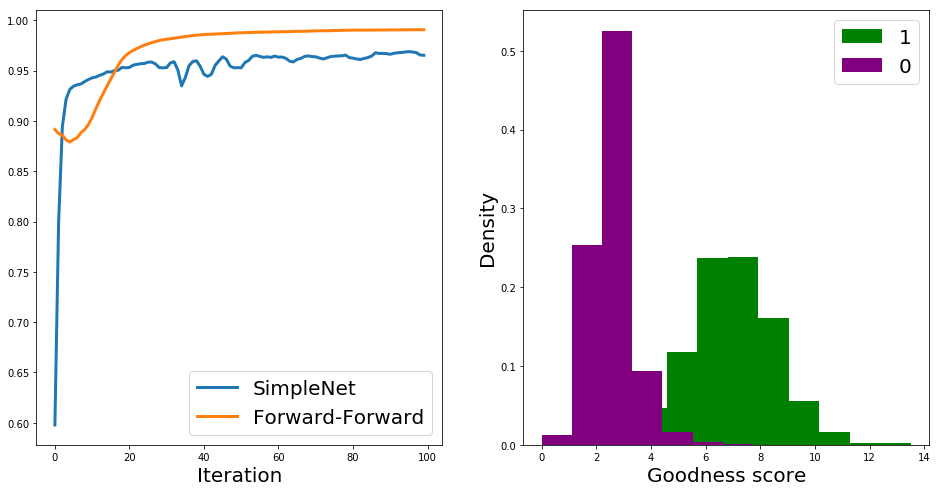

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))

ax1.plot(simple_net_performance,lw=3, label='SimpleNet')
ax1.plot(ff_net_performance,lw=3, label='Forward-Forward')
ax1.set_xlabel('Iteration', fontsize=20)
ax2.set_ylabel('ROC-AUC', fontsize=20)

ax2.hist(y_pred[test_y_arr==1], density=True, label='1', color='green')
ax2.hist(y_pred[test_y_arr==0], density=True, label='0', color='purple')
ax2.set_xlabel('Goodness score', fontsize=20)
ax2.set_ylabel('Density', fontsize=20)
ax1.legend(fontsize=20)
plt.legend(fontsize=20)